# Exclusion Plot Fitting

This code creates fit functions for the branching fraction constraints from Fig. 5. of [arXiv:1911.12575](https://arxiv.org/abs/1911.12575) and Fig. 3. of [arXiv:1901.04040](https://arxiv.org/abs/1901.04040) along both the mass and lifetime axes. The data was obtained by digitizing the plots with digitizeit.xyz.

In [1]:
#required dependencies
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from matplotlib import rc
rc('text', usetex=True)
from matplotlib.ticker import FormatStrFormatter

In [2]:
#helper functions

#unzips data of the form [(x1,y1), (x2,y2), ...] into the form [[x1,x2,...],[y1,y2,...]]
def unzip(tuple_list):
    return [[x for x,y in tuple_list], [y for x,y in tuple_list]]

#takes in tuples p1=(x1,y1), p2 = (x2,y2) and a number x, then outputs 
#the y-value of x for the line passing through p1 and p2
def line(p1, p2, x):
    m = (p2[1] - p1[1])/(p2[0] - p1[0])
    y = m*(x - p1[0]) + p1[1]
    return y

#returns a function which produces linear interpolation between the log of the input data,
#rather than linear interpolation between the data itself, since the data was digitized
#from a log-log plot
def log_interpolate(array, N=5):
    #convert data to log of data
    x_axis, y_axis = unzip(array)
    log_array = list(zip(np.log(x_axis), np.log(y_axis)))
    
    #the function to be returned
    def f(t):
        #if input t is outside of range of data to be interpolated, 
        #average over lines of N nearest points to that endpoint 
        #(rather than just the endpoint to avoid jagged function)
        if np.log(t) <= log_array[0][0]:
            avg_line = np.array([line(log_array[i-1], log_array[i], np.log(t)) for i in range(1,N+1)])
            return np.exp(np.mean(avg_line[np.isfinite(avg_line)]))
        
        if np.log(t) >= log_array[-1][0]:
            avg_line = np.array([line(log_array[-i-1], log_array[-i], np.log(t)) for i in range(1,N+1)])
            return np.exp(np.mean(avg_line[np.isfinite(avg_line)]))
        
        #otherwise, just interpolate on the line formed by the log
        #of the input and output data
        for i in range(len(log_array)-1):
            if log_array[i][0] <= np.log(t) < log_array[i+1][0]:
                return np.exp(line(log_array[i], log_array[i+1], np.log(t)))
    return f

#for ma_list and fn_list same length, creates a dictionary of the form {ma: data} 
#where data is generated from fn(ta) where fn is a function in fn_list
def func_to_dict(ma_list, ta, fn_list):
    data = np.array([[ta, [fn(t) for t in ta]] for fn in fn_list])
    return dict(zip(ma_list, data))

# LHC constraints on displaced vertices

Using the helper functions, we load in the data and create a dictionary "lifetime_dict" which is more ready for data processing. In particular, now all of the data is on the same lifetime axis, so it is much easier to fit a 2D function with mass and lifetime as the input.

In [3]:
#original, unprocessed digitized data (different number of points for different masses)
lifetime_data = dict(np.load('lifetime_data.npz'))

#functions created via log interpolation for each mass
lifetime_fns = [log_interpolate(data) for data in lifetime_data.values()]

#mass and lifetime axes of interest
lifetime_ma = np.array([15, 25, 40, 55])
lifetime_ta = 10.0**np.arange(-1.1,1.1,1/500) #pick a region of lifetimes over which all for plots overlap

#processed data, ready for fitting
lifetime_dict = func_to_dict(lifetime_ma, lifetime_ta, lifetime_fns)

One can compare the plot below to the Fig. of arXiv:1911.12575; the data is the same (especially within the error provided within the paper).

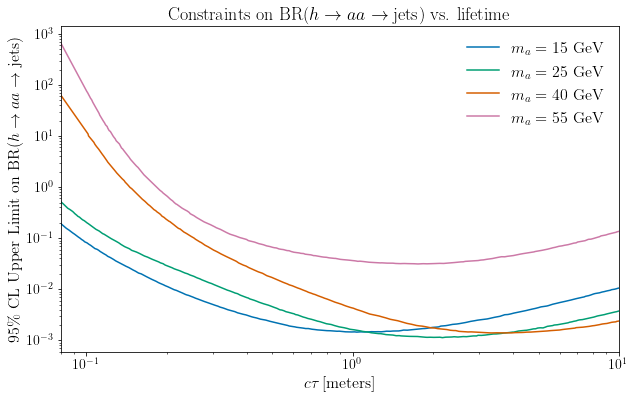

In [4]:
fig, ax = plt.subplots(figsize = (10, 6))
for key, val in lifetime_dict.items():
    label = "$m_a = " + str(key) + "\\textrm{ GeV}$"
    ax.plot(val[0], val[1], label = label)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(8e-2,1e1)
ax.set_title('$\\textrm{Constraints on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets}) \\textrm{ vs. lifetime}$',
             fontsize = 18)
ax.set_xlabel('$c\\tau$\\,\\textrm{[meters]}', fontsize = 16)
ax.set_ylabel('$95\\%\\textrm{ CL Upper Limit on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets})$', fontsize = 16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(prop={"size":16}, frameon = False, loc = "upper right")

In [5]:
#a few more helper functions

#takes in a dictionary of the form {ma: np.array([ta_data, BR_data])} and
#returns a flattened list of the form 
#[[(ma1, ta1), (ma1, ta2), ..., (ma2, ta1), (ma2, ta2), ...], [BR11, BR12, ..., BR21, BR22, ...]]
#which is a form that can easily be sent 
def make_data_list(data_dict):
    x_data = np.array([np.array([key*np.ones_like(data_dict[key][0]), data_dict[key][0]])
                       for key in data_dict.keys()])
    y_data = np.array([np.array(data_dict[key][1])
                       for key in data_dict.keys()])
    return [x_data, y_data]

#takes in a 
def make_data_dict(data_list):
    x_data = data_list[0]
    y_data = data_list[1]
    ma = [x[0][0] for x in x_data]
    ta = [x[1] for x in x_data]
    data = np.array([[ta[i],y_data[i]] for i in range(len(ma))])
    return dict(zip(ma, data))

#takes a data list of the form
#[[(ma1, ta1), (ma1, ta2), ..., (ma2, ta1), (ma2, ta2), ...], [BR11, BR12, ..., BR21, BR22, ...]]
#and uses geometric mean to interpolate data between masses, so that for
# ma = (ma1 + ma2)/2 at lifetime ta, the corresponding branching fraction
#is BR(ma, ta) = sqrt(BR(ma1,ta)*BR(ma2,ta)). The choice of the geometric
#mean is arbitrary, and a different method of mass interpolation should
#also work for these purposes (set interp_type to 'lin' to check this out).
#The main goal is to add midpoint data in order to avoid overfitting.
def mass_interpolate(data_list, interp_type = 'log'):
    new_x_data = []
    new_y_data = []
    for i in range(len(data_list[0]) - 1):
        data = data_list[0][i]
        new_x_data.append(data)
        new_y_data.append(data_list[1][i])
        x = (data_list[0][i] + data_list[0][i+1])/2
        if interp_type == 'log':
            y = (data_list[1][i]*data_list[1][i+1])**(1/2) #geometric mean
        if interp_type == 'lin':
            y = (data_list[1][i]+data_list[1][i+1])/2 #arithmetic mean
        new_x_data.append(x)
        new_y_data.append(y)
    new_x_data.append(data_list[0][-1])
    new_y_data.append(data_list[1][-1])
    return [np.array(new_x_data), np.array(new_y_data)]

In [6]:
lifetime_fit_list = mass_interpolate(make_data_list(lifetime_dict))
lifetime_fit_dict = make_data_dict(lifetime_fit_list)

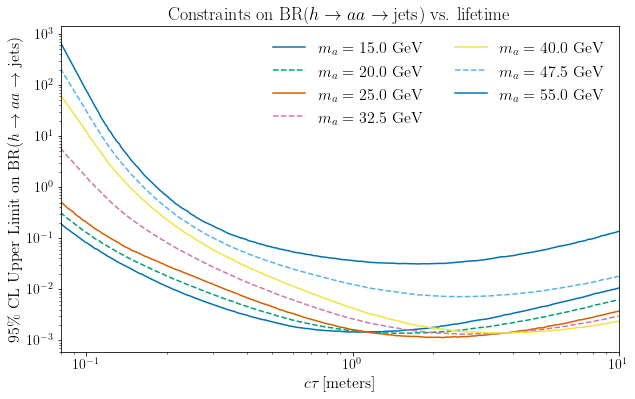

In [7]:
fig, ax = plt.subplots(figsize = (10,6))
for i, (key, val) in enumerate(lifetime_fit_dict.items()):
    label = "$m_a = " + str(float(key)) + "\\textrm{ GeV}$"
    if i%2 == 0:
        linestyle = 'solid'
    else:
        linestyle = 'dashed'
    ax.plot(val[0], val[1], label = label, linestyle = linestyle)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(8e-2,1e1)
ax.set_title('$\\textrm{Constraints on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets}) \\textrm{ vs. lifetime}$',
             fontsize = 18)
ax.set_xlabel('$c\\tau$\\,\\textrm{[meters]}', fontsize = 16)
ax.set_ylabel('$95\\%\\textrm{ CL Upper Limit on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets})$', fontsize = 16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(prop={"size":16}, frameon = False, loc = 'upper right', ncol=2)

We choose the fit function to be of the form $f(m_a,\tau_a) = g(m_a, \log{\tau_a})$ where $g(x, y)$ is a polynomial function which is piecewise in $y$. In particular, it is given here by
$$ g(x, y) = \begin{cases}\sum_{n=0}^2\ell_n(x)y^n & x \leq L\\
\sum_{n=0}^8m_n(x)y^n & L < x < R\\
\sum_{n=0}^2r_n(x)y^n & x \geq R
\end{cases}$$
where $\ell_n$, $r_n$ and $m_n$ are third-order polynomials in $x$ and their coefficients are constrained such that $g(x,y)$ is a $C^1$ function. $L$ and $R$ have been chosen to be $\log_{10}(0.2 \textrm{ m})$ and $\log_{10}(2\textrm{ m})$, respectively (the fit function had a tough time determining them if they were left as free parameters).

In [8]:
#fit function

#polynomial helper function. constructs a polynomial from a list of coefficients
def poly(x, coeff):
    n = len(coeff)
    result = np.array([coeff[i]*x**i for i in range(n)])
    return np.sum(result, axis=0)


#X is (ma, ta), lij, mij, rij are the coefficients of the left, mid, and right polynomials.
#The first index refers to the degree of the polynomial in ta, and the second index refers
#to the degree of the polynomial in ma.
def piecewise_fit(X,l00,l01,l02,l03,l10,l11,l12,l13,l20,l21,l22,l23,
                m40,m41,m42,m43,m50,m51,m52,m53,m60,m61,m62,m63,
                m70,m71,m72,m73,m80,m81,m82,m83,r00,r01,r02,r03,r10,
                r11,r12,r13,r20,r21,r22,r23):
    ma, ta = X
    
    #we choose the left and right connections to be at tau = 0.2 and tau = 2; the
    #least squares fit algorithm had trouble determining what they should be otherwise
    L = np.log10(0.2)
    R = np.log10(2)

    l0list = np.array([l00, l01, l02, l03])
    l1list = np.array([l10, l11, l12, l13])
    l2list = np.array([l20, l21, l22, l23])

    r0list = np.array([r00, r01, r02, r03])
    r1list = np.array([r10, r11, r12, r13])
    r2list = np.array([r20, r21, r22, r23])
    
    m4list = np.array([m40, m41, m42, m43])
    m5list = np.array([m50, m51, m52, m53])
    m6list = np.array([m60, m61, m62, m63])
    m7list = np.array([m70, m71, m72, m73])
    m8list = np.array([m80, m81, m82, m83])
    
    #rather than letting the fit function choose m0i - m3i, these are
    #chosen by forcing the fit function to be continuous and differentiable
    #at ta = L and ta = R. This corresponds to solving:
    # M*(m0,m1,m2,m3) = F(L,R,li,ri,m4,m5,m6,m7,m8)
    #where 
    #     [1, L, L^2, L^3]
    #     [1, R, R^2, R^3]
    # M = [0, 1, 2L, 3L^2]
    #     [0, 1, 2R, 2R^2]
    #and F is a vector function, with components
    #
    # F1 = l0 + l1*L + l2*L^2 - m4*L^4 - m5*L^5 - m6*L^6 - m7*L^7 - m8*L^8
    # F2 = r0 + r1*R + r2*R^2 - m4*R^4 - m5*R^5 - m6*R^6 - m7*R^7 - m8*R^8
    # F3 = l1 + 2*l2*L - 4*m4*L^3 - 5*m5*L^4 - 6*m6*L^6 - 7*m7*L^7 - 8*m8*R^8
    # F4 = r1 + 2*r2*R - 4*m4*R^3 - 5*m5*R^4 - 6*m6*R^6 - 7*m7*R^7 - 8*m8*R^8
    #
    #Hence, the first and second rows preserve continuity at L and R, and the 
    #third and fourth rows preserve differentiability at L and R.
    #
    #This is then solved by (m0,m1,m2,m3) = inv(M)F(L,R,li,ri,m4,m5,m6,m7,m8)
    
    M = np.array([[1,L,L**2,L**3],[1,R,R**2,R**3],[0,1,2*L,3*L**2],[0,1,2*R,3*R**2]])
    
    F = np.array([poly(L, np.array([l0list,l1list,l2list])) - L**4*poly(L, np.array([m4list,m5list,m6list,m7list,m8list])),
                  poly(R, np.array([r0list,r1list,r2list])) - R**4*poly(R, np.array([m4list,m5list,m6list,m7list,m8list])),
                  poly(L, np.array([l1list,2*l2list])) - L**3*poly(L, np.array([4*m4list,5*m5list,6*m6list,7*m7list,8*m8list])),
                  poly(R, np.array([r1list,2*r2list])) - R**3*poly(R, np.array([4*m4list,5*m5list,6*m6list,7*m7list,8*m8list]))])
    
    
    invM = np.linalg.inv(M)
    mlist = np.array([np.dot(invM, F[:,i]) for i in range(4)]).transpose()
    mlist = [mlist[0], mlist[1], mlist[2], mlist[3], m4list, m5list, m6list, m7list, m8list]
    
    #coefficients for the left, middle, and right polynomials
    lcoeff = np.array([poly(ma, l0list), poly(ma, l1list), poly(ma, l2list)])
    mcoeff = np.array([poly(ma, m) for m in mlist])
    rcoeff = np.array([poly(ma, r0list), poly(ma, r1list), poly(ma, r2list)])
    
    #use heaviside to determine which region you're in (left, mid, right),
    #then use the corresponding polynomial for that region
    left = poly(ta, lcoeff)*np.heaviside(L-ta, 0.5)
    right = poly(ta, rcoeff)*np.heaviside(ta-R, 0.5)
    mid = poly(ta, mcoeff)*np.heaviside(ta-L, 0.5)*np.heaviside(R-ta, 0.5)
    
    return left + mid + right

Now that we have the function we wish to fit, we can process the data into the right shape and find the fit parameters:

In [9]:
fit_x_data = np.transpose(lifetime_fit_list[0],axes=[1,0,2]).reshape(2, -1)
fit_x_data = (fit_x_data[0], np.log10(fit_x_data[1]))
fit_y_data = np.log10(lifetime_fit_list[1].flatten())
pvar, pcov = curve_fit(piecewise_fit, fit_x_data, fit_y_data)

As we can see, the fit function is able to reproduce the data from the plots with good accuracy (definitely within the error of the original plot):

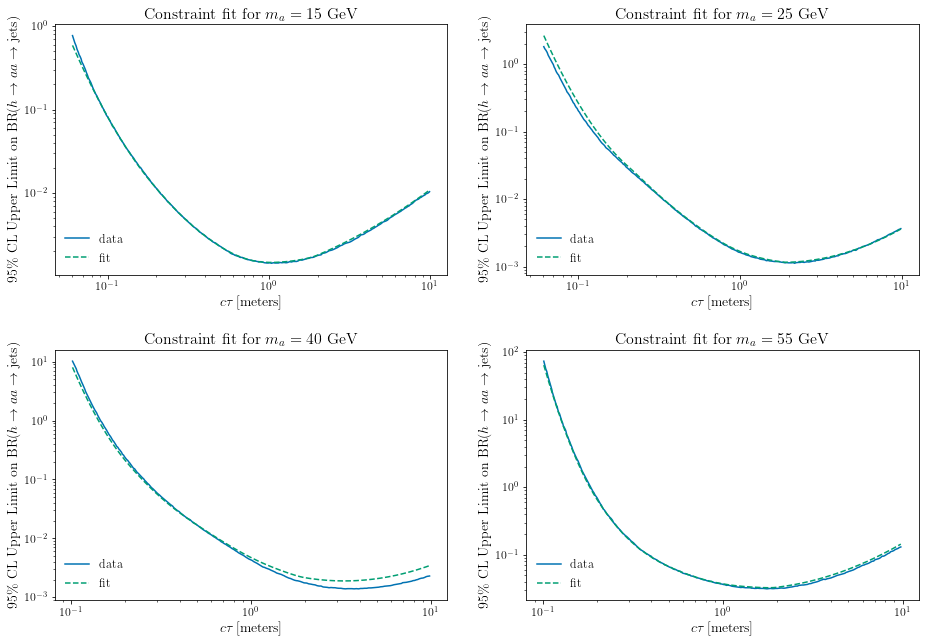

In [10]:
fig, axes = plt.subplots(2,2, figsize = (15, 10))
masses = list(lifetime_dict.keys())
for i, ax in enumerate(axes.flatten()):
    fitted_data = np.array(unzip(list(lifetime_data.values())[i]))
    ax.plot(fitted_data[0], fitted_data[1],label = "$\\textrm{data}$")
    ax.plot(fitted_data[0],10.0**piecewise_fit((masses[i],np.log10(fitted_data[0])), *pvar),
            linestyle = 'dashed',label = "$\\textrm{fit}$")
    ax.set_xscale('log')
    ax.set_yscale('log')
    title = '$\\textrm{Constraint fit for }m_a = ' + str(masses[i]) + '\\textrm{ GeV}$'
    ax.set_title(title, fontsize = 16)
    ax.set_xlabel('$c\\tau$\\,\\textrm{[meters]}',
                  fontsize = 14)
    ax.set_ylabel('$95\\%\\textrm{ CL Upper Limit on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets})$',
                  fontsize = 14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(prop={"size":12}, frameon = False, loc = "lower left")
fig.subplots_adjust(bottom = 0, top = 0.8)


fig.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.2,  
                    hspace=0.3) 

We can also plot the function along the mass axis for given lifetimes. The dependence along the mass axis is smooth, which is important because it indicates that we did not overfit along the axis which had minimal data. Although the behaviour is smooth, the dependence at the endpoints ($m_a < 10\,\text{GeV}$ and $m_a > 55\,\text{GeV}$) should be taken with a grain of salt.

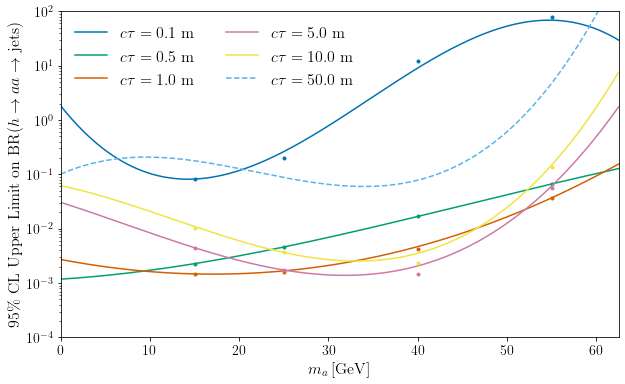

In [11]:
plot_masses = np.arange(0, 62.5, 0.01)
plot_ta = np.array([0.1,0.5,1,5,10])

mass_fit_fig, ax = plt.subplots(figsize = (10,6))
for i, ta in enumerate(plot_ta):
    color = colors[i%len(colors)]
    label = "$c\\tau = " + str(np.round(ta,1)) + "\\textrm{ m}$"
    ax.plot(plot_masses, 10.0**piecewise_fit((plot_masses, np.log10(ta)), *pvar), color = color, label = label)
    ax.plot([15, 25, 40, 55],[lifetime_fns[i](ta) for i in range(4)],'.', color = color)
ta = 50.0
ax.plot(plot_masses, 10.0**piecewise_fit((plot_masses, np.log10(ta)), *pvar), color = colors[i+1],
         linestyle = 'dashed',label = "$c\\tau = " + str(ta) + "\\textrm{ m}$" )
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('$95\\%\\textrm{ CL Upper Limit on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets})$', fontsize = 16)
ax.set_xlabel('$m_{a}\\,\\textrm{[GeV]}$', fontsize = 16)
ax.set_ylim(1e-4,1e2)
ax.set_xlim(0,62.5)
ax.legend(prop = {"size":16}, frameon = False, ncol=2)

There is one final complication. At small masses, the fit function is ill-behaved at large lifetimes:

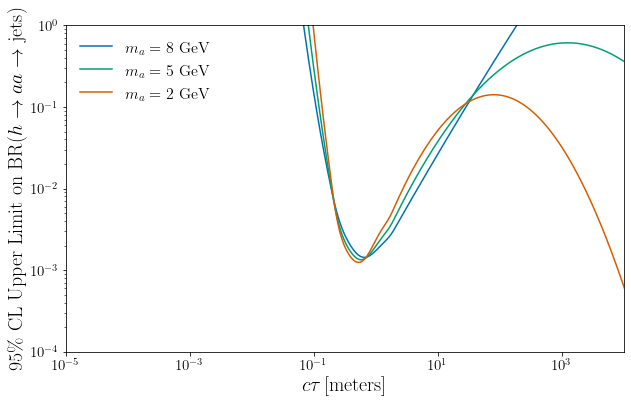

In [12]:
BR_lifetime_fig_I, ax = plt.subplots(figsize = (10,6))

plot_masses = np.array([8, 5, 2])
plot_ta = 10.0**np.arange(-10.0,10,0.01)

BR_constraint = 10.0**(np.array([piecewise_fit((m, np.log10(plot_ta)),*pvar) for i, m in enumerate(plot_masses)]))

for i,ma in enumerate(plot_masses):
    label = "$m_a = " + str(ma) + "\ \\textrm{GeV}$"
    plt.plot(plot_ta, BR_constraint[i], label = label)

plt.xscale('log')
plt.yscale('log')
ax.set_ylim(1e-4,1e0)
ax.set_xlim(1e-5,1e4)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlabel('$c\\tau\\,\\textrm{[meters]}$', fontsize = 20)
ax.set_ylabel('$95\\%\\textrm{ CL Upper Limit on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets})$', fontsize = 20)
ax.legend(prop={"size":16}, frameon = False, loc = "upper left")

This is clearly an artifact of the fit not capturing the appropriate behavior in this region. Physically, the branching fraction should be less constrained at large lifetimes, so we expect that the curve will continue to increase. In particular, it can be shown that on a log-log plot, the dependence should be linear with a slope of 2 at large lifetimes. Hence, for $m_a < 9\ \text{GeV}$ we change the fit function so that once the slope of the curve is 2, it stays linear with slope 2:

In [13]:
def fitted_BR(ma, ta):
    if hasattr(ma, '__iter__'):
        return np.array([fitted_BR(m, ta) for m in ma])
   
    br = 10.0**piecewise_fit((ma, np.log10(ta)), *pvar)
    
    if ma > 9:
        return br
    else:
        slope = np.array([np.log10(br[i+1]/br[i])/np.log10(ta[i+1]/ta[i]) for i in range(len(ta) - 1)])
        idx = np.nanargmin(abs(slope - 2))
        
        p1 = (np.log10(ta[idx]), np.log10(br[idx]))
        p2 = (np.log10(ta[idx+1]), np.log10(br[idx+1]))

        logline = 10.0**line(p1, p2, np.log10(ta))
        
        return br*np.heaviside(ta[idx]-ta, 0.5) + logline*np.heaviside(ta-ta[idx], 0.5)

<ipython-input-13-179f48577ee8>:5: RuntimeWarning: overflow encountered in power
  br = 10.0**piecewise_fit((ma, np.log10(ta)), *pvar)
/home/roman/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


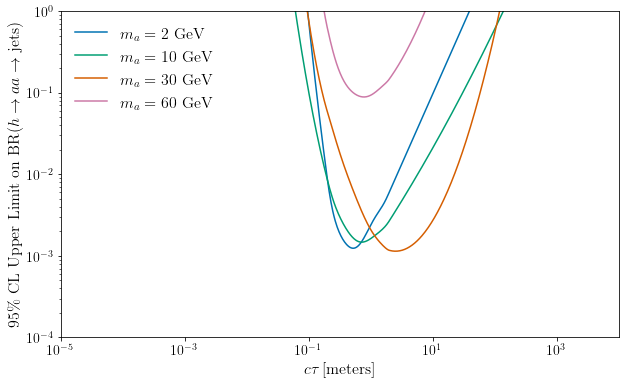

In [14]:
BR_lifetime_fig_III, ax = plt.subplots(figsize = (10,6))

plot_masses = np.array([2,10,30,60])
plot_ta = 10.0**np.arange(-10.0,10,0.01)

BR_constraint = fitted_BR(plot_masses, plot_ta)

for i,ma in enumerate(plot_masses):
    label = "$m_a = " + str(ma) + "\ \\textrm{GeV}$"
    plt.plot(plot_ta, BR_constraint[i],label = label)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,1e0)
ax.set_xlim(1e-5,1e4)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('$c\\tau\\,\\textrm{[meters]}$', fontsize = 16)
ax.set_ylabel('$95\\%\\textrm{ CL Upper Limit on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets})$', fontsize = 16)
ax.legend(prop={"size":16}, frameon = False, loc = "upper left")

Now the fit function is well behaved over the entire range of masses considered (2 GeV to 62.5 GeV)

# Projections from MATHUSLA

We now repeat the process for MATHUSLA, but with a moderately different fit function. First, we load and proces the data:

In [15]:
MATH_data = list(np.load('mathusla_data.npz').values()) 
MATH_fns = [log_interpolate(list(zip(data[0],data[1])),5) for data in MATH_data]

MATH_ma = np.array([5, 20, 40])
MATH_ta = 10.0**np.arange(-2,8,1/500)

MATH_dict = func_to_dict(MATH_ma, MATH_ta, MATH_fns)

<ipython-input-2-c568e14a4b0b>:10: RuntimeWarning: divide by zero encountered in double_scalars
  m = (p2[1] - p1[1])/(p2[0] - p1[0])


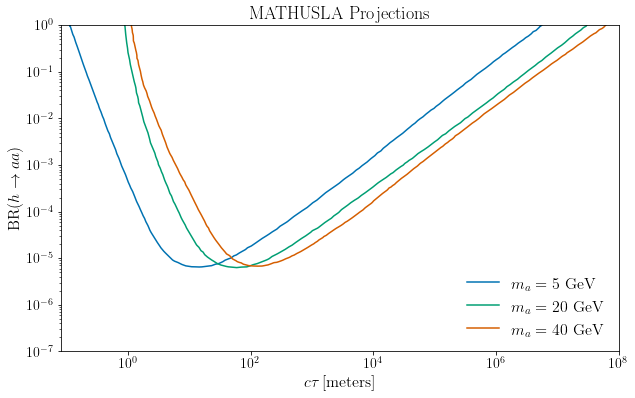

In [16]:
MATH_fig, ax = plt.subplots(figsize = (10, 6))

for i, (key, val) in enumerate(MATH_dict.items()):
    label = "$m_a = " + str(key) + "\\textrm{ GeV}$"
    ax.plot(val[0], val[1], label = label)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(8e-2,1e8)
ax.set_ylim(1e-7,1e0)
ax.set_title('$\\textrm{MATHUSLA Projections}$',fontsize = 18)
ax.set_xlabel('$c\\tau\\,\\textrm{[meters]}$', fontsize = 16)
ax.set_ylabel('$\\textrm{BR}(h\\rightarrow aa)$', fontsize = 16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(prop={"size":16}, frameon = False, loc = "lower right", ncol = 1)

An argument is made in an older MATHUSLA proposal ([arXiv:1806.07396](https://arxiv.org/abs/1806.07396)) about the lifetime dependence of the branching fraction projection. The probability that a particle decays within a region $L_1\leq x \leq L_2$ is given by

$$P_{\text{decay}}(bc\tau, L_1, L_2) = e^{-L_1/bc\tau} - e^{-L_2/bc\tau} \approx \frac{L_2 - L_1}{bc\tau}$$

where $b = m_h/2m_a$. The probability that the particles reach MATHUSLA is then

$$P_\text{decay}^{\text{MATH}}(c\tau) = \epsilon_{\text{geom}}P_{\text{decay}}(bc\tau, L_1, L_2),$$

where $(L_1, L_2) = (200\text{ m},\, 230\text{ m})$ and $\epsilon_{\text{geom}} = 0.5$.

The projected exclusion limits are then given by

$$(\epsilon \sigma)^{\text{MATHUSLA limit}} \approx \frac{4}{2\mathcal{L}P_{\text{decay}}(c\tau)}.$$

We plot this vs. the simulated exclusion limits below, but with $(L_1, L_2) = (180\text{ m}, 200\text{ m})$, due to the difference in the dimensions between the two References. The approximation $(\epsilon \sigma)^{\text{MATHUSLA limit}}$ is represented by the dashed curves, whereas the exclusion data we wish to fit is represented by the solid curves.

In [17]:
crossx_Hsm = 55000 #Higgs production crossx, pb
mh = 125 #Higgs mass
def Pdecay(x, L1, L2):
    return np.exp(-L1/x) - np.exp(-L2/x)

def Pdecay_MATH(ta, ma, L1, L2):
    b = mh/(2*ma)
    x = b*ta
    return 0.05*Pdecay(x, L1, L2)

def Nobs(ta, ma, L1, L2):
    return (crossx_Hsm*3000)*2*Pdecay_MATH(ta,ma,L1,L2)

def MATH_approx(ta, ma, L1, L2):
    return 4/Nobs(ta, ma, L1, L2)

<ipython-input-17-f4c8e6cf2f00>:15: RuntimeWarning: divide by zero encountered in true_divide
  return 4/Nobs(ta, ma, L1, L2)
<ipython-input-17-f4c8e6cf2f00>:15: RuntimeWarning: overflow encountered in true_divide
  return 4/Nobs(ta, ma, L1, L2)
<ipython-input-17-f4c8e6cf2f00>:15: RuntimeWarning: divide by zero encountered in true_divide
  return 4/Nobs(ta, ma, L1, L2)
<ipython-input-17-f4c8e6cf2f00>:15: RuntimeWarning: overflow encountered in true_divide
  return 4/Nobs(ta, ma, L1, L2)
<ipython-input-17-f4c8e6cf2f00>:15: RuntimeWarning: divide by zero encountered in true_divide
  return 4/Nobs(ta, ma, L1, L2)
<ipython-input-17-f4c8e6cf2f00>:15: RuntimeWarning: overflow encountered in true_divide
  return 4/Nobs(ta, ma, L1, L2)
/home/roman/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


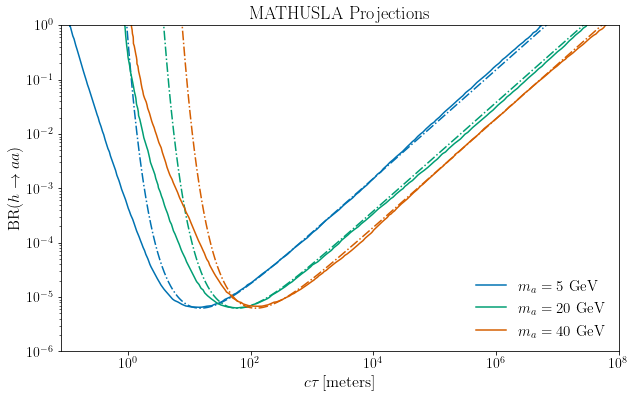

In [18]:
MATH_fig_approx, ax = plt.subplots(figsize = (10, 6))

for i, (key, val) in enumerate(MATH_dict.items()):
    label = "$m_a = " + str(key) + "\\textrm{ GeV}$"
    ax.plot(val[0], val[1], label = label)
    ax.plot(val[0], MATH_approx(val[0], key, 180, 200), color = colors[i], linestyle = 'dashdot')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(8e-2,1e8)
ax.set_ylim(1e-6,1e0)
ax.set_title('$\\textrm{MATHUSLA Projections}$',fontsize = 18)
ax.set_xlabel('$c\\tau\\,\\textrm{[meters]}$', fontsize = 16)
ax.set_ylabel('$\\textrm{BR}(h\\rightarrow aa)$', fontsize = 16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(prop={"size":15}, frameon = False, loc = "lower right")

The plots are in good agreement for large lifetimes, but not for low lifetimes. Hence, in this section we attempt to plot the left part of the plots, with the condition that it is continuous and differentiable. To do this, we note that the minimum of the projected exclusion limits is at

$$ \tau_{\text{min}} = \frac{L_2 - L_1}{b\log{(L_2/L_1)}}$$

Since the approximation provided by arXiv:1806.07396 works to the right of this point, we simply fit the curve to the left of this lifetime with a polynomial, with the condition of continuity and differentiability at $\tau_{\text{min}}$. We use a sixth order polynomial in log lifetime, and a third order polynomial in mass.

In [19]:
#fit
def piecewise_fit_MATH(X, m10, m11, m12, m13, m20, m21, m22, m23, m30, m31, m32, m33,
                       m40, m41, m42, m43, m50, m51, m52, m53, m60, m61, m62, m63):
    ma, ta = X
    b = 125/(2*ma)
    
    #lifetime which makes exclusion limits a minimum
    M = (200 - 180)/(b*np.log(200/180))
    
    #minimum of the exclusion limits
    A0 = MATH_approx(M, ma, 180, 200)

    #polynomial coefficients
    m1list = np.array([m10, m11, m12, m13])
    m2list = np.array([m20, m21, m22, m23])
    m3list = np.array([m30, m31, m32, m33])
    m4list = np.array([m40, m41, m42, m43])
    m5list = np.array([m50, m51, m52, m53])
    m6list = np.array([m60, m61, m62, m63])
    
    mlist = np.array([m1list, m2list, m3list, m4list, m5list, m6list])
    mcoeff = np.array([poly(ma, m) for m in mlist])

    #this is the most general form for a sixth order polynomial with value log(A0) and slope 0 at ta=M
    left = np.log10(A0) + (ta - np.log10(M))**2*poly((ta - np.log10(M))**2, mcoeff)

    return left

Now, we process data (once again interpolating between the masses) and find the fit parameters.

In [20]:
MATH_fit_list = mass_interpolate(make_data_list(MATH_dict))
MATH_fit_dict = make_data_dict(MATH_fit_list)

MATH_fit_x_data = np.transpose(MATH_fit_list[0],axes=[1,0,2]).reshape(2, -1)
indx = MATH_fit_x_data[1] < 1e2
MATH_fit_x_data = (MATH_fit_x_data[0][indx], np.log10(MATH_fit_x_data[1][indx]))
MATH_fit_y_data = np.log10(MATH_fit_list[1].flatten()[indx])
pvar, pcov = curve_fit(piecewise_fit_MATH, MATH_fit_x_data, MATH_fit_y_data)

The function MATH_fit patches together the fit for $\tau < \tau_{\text{min}}$, and the approximation from the paper for $\tau > \tau_{\text{min}}$.

In [21]:
#fit function
def MATH_fit(ma, ta):
    if hasattr(ma, 'iter'):
        return np.array([MATH_fit(m, ta) for m in ma])
    b = 125/(2*ma)
    M = (200 - 180)/(b*np.log(200/180))
    left = 10.0**piecewise_fit_MATH((ma,np.log10(ta)), *pvar)
    right = MATH_approx(ta, ma, 180, 200)
    return left*np.heaviside(M - ta,0.5) + right*np.heaviside(ta - M,0.5)

The resulting plots are shown below:

<ipython-input-21-af83f1d748fc>:7: RuntimeWarning: overflow encountered in power
  left = 10.0**piecewise_fit_MATH((ma,np.log10(ta)), *pvar)
<ipython-input-21-af83f1d748fc>:9: RuntimeWarning: invalid value encountered in multiply
  return left*np.heaviside(M - ta,0.5) + right*np.heaviside(ta - M,0.5)


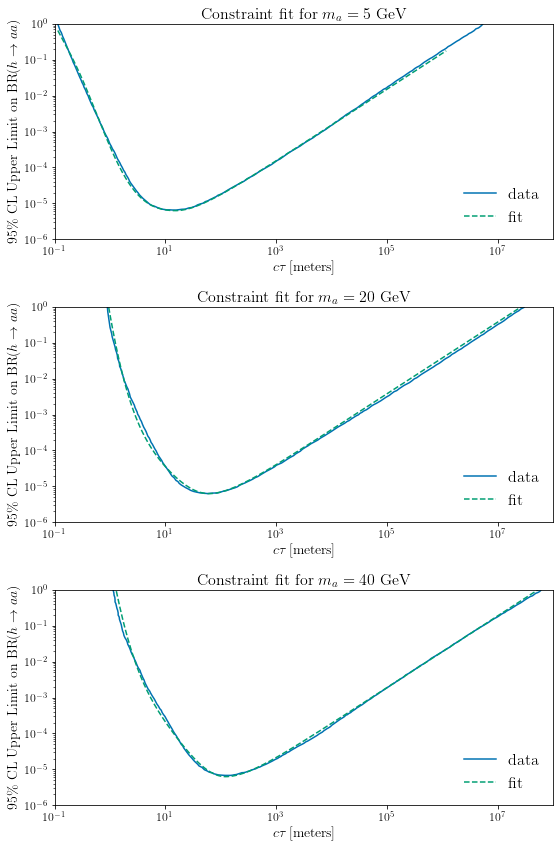

In [22]:
fig, axes = plt.subplots(3,1, figsize = (8, 12))
masses = list(MATH_dict.keys())
for i, ax in enumerate(axes.flatten()):
    fitted_data = MATH_data[i]
    ax.plot(fitted_data[0], fitted_data[1],
            label="$\\textrm{data}$")
    ax.plot(fitted_data[0],MATH_fit(masses[i], fitted_data[0]), linestyle = 'dashed',
            label="$\\textrm{fit}$")
    ax.set_xscale('log')
    ax.set_yscale('log')
    title = '$\\textrm{Constraint fit for }m_a = ' + str(masses[i]) + '\\textrm{ GeV}$'
    ax.set_title(title, fontsize = 16)
    ax.set_xlabel('$c\\tau$\\,\\textrm{[meters]}', fontsize = 14)
    ax.set_ylabel('$95\\%\\textrm{ CL Upper Limit on }\\textrm{BR}(h\\rightarrow aa)$', fontsize = 14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim(1e-6,1e0)
    ax.set_xlim(1e-1,1e8)
    ax.legend(prop={"size":16}, frameon = False, loc = "lower right")

fig.tight_layout(pad=1.5)

Hence, the fit appears to agree well with the data both to the left and right of the minimum.